## 📙 Import libraries and modules

In [1]:
# Importing essential libraries
import gc
import os
import random
import warnings
import numpy as np
import pandas as pd
from IPython.display import display

# PyTorch for deep learning
import timm
import torch
import torch.nn as nn  
import torch.optim as optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import CosineAnnealingLR

# torchvision for image processing and augmentation
import torchvision.transforms as transforms

# Suppressing minor warnings to keep the output clean
warnings.filterwarnings('ignore', category=Warning)

# Reclaim memory no longer in use.
gc.collect()

46

## ⚙️ Configuration

In [2]:
# Configuration class containing hyperparameters and settings
class Config:
    seed = 42 
    image_transform = transforms.Resize((512,512))  
    batch_size = 16
    num_epochs = 9
    num_folds = 5

# Set the seed for reproducibility across multiple libraries
def set_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    
set_seed(Config.seed)

# Define the 'Kullback Leibler Divergence' loss function
def KL_loss(p,q):
    epsilon=10**(-15)
    p=torch.clip(p,epsilon,1-epsilon)
    q = nn.functional.log_softmax(q,dim=1)
    return torch.mean(torch.sum(p*(torch.log(p)-q),dim=1))

# Reclaim memory no longer in use.
gc.collect()

0

## 📂 Data Loading

In [3]:
# Load training data
train_df = pd.read_csv("/kaggle/input/hms-harmful-brain-activity-classification/train.csv")

# Filter out cases where the total number of votes is less than 5
indices_eliminados = train_df.index[train_df[['seizure_vote','lpd_vote','gpd_vote','lrda_vote','grda_vote','other_vote']].sum(axis=1) < 4]
train_df = train_df.drop(indices_eliminados)
train_df = train_df.reset_index()

train_df

,index,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,9,2277392603,0,0.0,924234,0,0.0,1978807404,30539,GPD,0,0,5,0,1,5
1,10,2277392603,1,2.0,924234,1,2.0,134339127,30539,GPD,0,0,5,0,1,5
2,11,722738444,0,0.0,999431,0,0.0,557980729,56885,LRDA,0,1,0,14,0,1
3,12,722738444,1,2.0,999431,1,2.0,1949834128,56885,LRDA,0,1,0,14,0,1
4,13,722738444,2,4.0,999431,2,4.0,3790867376,56885,LRDA,0,1,0,14,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48252,106778,2750557840,2,10.0,2146188334,2,10.0,621803104,21884,Other,0,0,0,0,0,13
48253,106780,3910994355,0,0.0,2146798838,0,0.0,4272062867,28488,LPD,0,9,0,2,0,7
48254,106781,3938393892,0,0.0,2146798838,1,60.0,2587113091,28488,LPD,0,9,0,2,0,7
48255,106782,3938393892,1,4.0,2146798838,2,64.0,827904671,28488,LPD,0,9,0,2,0,7


In [4]:
# Define labels for classification
labels = ['seizure', 'lpd', 'gpd', 'lrda', 'grda', 'other']

# Initialize an empty DataFrame for storing features
train_feats = pd.DataFrame()

# Aggregate votes for each label and merge into train_feats DataFrame
for label in labels:
    # Group by 'spectrogram_id' and sum the votes for the current label
    group = train_df[f'{label}_vote'].groupby(train_df['spectrogram_id']).sum()

    # Create a DataFrame from the grouped data
    label_vote_sum = pd.DataFrame({'spectrogram_id': group.index, f'{label}_vote_sum': group.values})

    # Initialize train_feats with the first label or merge subsequent labels
    if label == 'seizure':
        train_feats = label_vote_sum
    else:
        train_feats = train_feats.merge(label_vote_sum, on='spectrogram_id', how='left')

# Add a column to sum all votes
train_feats['total_vote'] = 0
for label in labels:
    train_feats['total_vote'] += train_feats[f'{label}_vote_sum']


# Calculate and store the normalized vote for each label
for label in labels:
    train_feats[f'{label}_vote'] = train_feats[f'{label}_vote_sum'] / train_feats['total_vote']

# Select relevant columns for the training features
choose_cols = ['spectrogram_id']
for label in labels:
    choose_cols += [f'{label}_vote']
train_feats = train_feats[choose_cols]

# Add a column with the path to the spectrogram files
train_feats['path'] = train_feats['spectrogram_id'].apply(lambda x: "/kaggle/input/hms-harmful-brain-activity-classification/train_spectrograms/" + str(x) + ".parquet")

# Reclaim memory no longer in use.
gc.collect()

0

In [5]:
# Fix errors in labels
target_mapping = {'seizure_vote': 'Seizure', 'lpd_vote': 'LPD', 'gpd_vote': 'GPD', 'lrda_vote': 'LRDA', 'grda_vote': 'GRDA', 'other_vote': 'Other'}

# #Obtain the maximum label for each row
voto_maximo_columna = train_feats[['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']].idxmax(axis=1)

# Actualize column target
train_feats['target'] = voto_maximo_columna.map(target_mapping)

train_feats

,spectrogram_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,path,target
0,924234,0.00,0.000000,0.454545,0.000000,0.090909,0.454545,/kaggle/input/hms-harmful-brain-activity-class...,GPD
1,999431,0.00,0.062500,0.000000,0.875000,0.000000,0.062500,/kaggle/input/hms-harmful-brain-activity-class...,LRDA
2,1219001,0.60,0.000000,0.400000,0.000000,0.000000,0.000000,/kaggle/input/hms-harmful-brain-activity-class...,Seizure
3,1353070,0.00,0.000000,0.357143,0.000000,0.000000,0.642857,/kaggle/input/hms-harmful-brain-activity-class...,Other
4,1872874,0.25,0.250000,0.000000,0.500000,0.000000,0.000000,/kaggle/input/hms-harmful-brain-activity-class...,LRDA
...,...,...,...,...,...,...,...,...,...
5513,2145983945,0.00,0.066667,0.000000,0.666667,0.000000,0.266667,/kaggle/input/hms-harmful-brain-activity-class...,LRDA
5514,2146166212,0.00,0.000000,0.000000,0.500000,0.000000,0.500000,/kaggle/input/hms-harmful-brain-activity-class...,LRDA
5515,2146170054,0.60,0.000000,0.400000,0.000000,0.000000,0.000000,/kaggle/input/hms-harmful-brain-activity-class...,Seizure
5516,2146188334,0.00,0.000000,0.000000,0.000000,0.000000,1.000000,/kaggle/input/hms-harmful-brain-activity-class...,Other


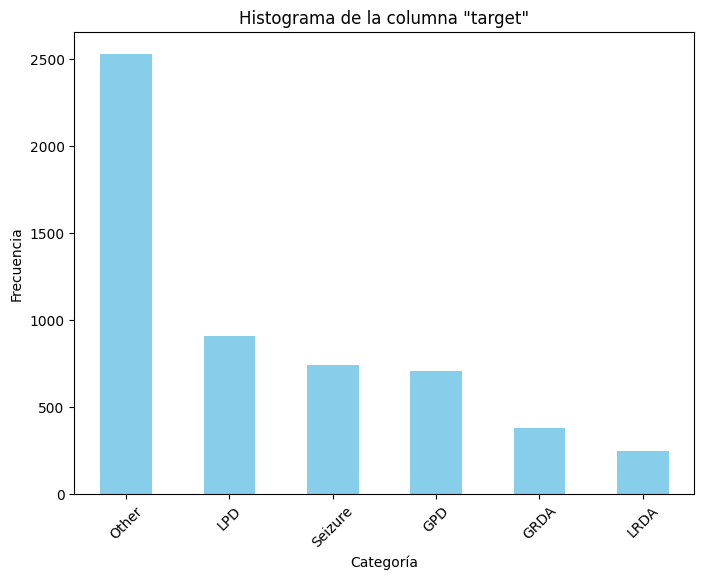

5518


In [6]:
from matplotlib import pyplot as plt
plt.figure(figsize=(8, 6))
train_feats['target'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Histograma de la columna "target"')
plt.xlabel('Categoría')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45)
plt.show()

print(len(train_feats))

train_feats = train_feats.drop('target', axis=1)

## 🎰 Data Preprocessing

In [7]:
def get_batch(paths, batch_size=Config.batch_size):
    # Set a small epsilon to avoid division by zero
    eps = 1e-6

    # Initialize a list to store batch data
    batch_data = []

    # Iterate over each path in the provided paths
    for path in paths:
        # Read data from parquet file
        data = pd.read_parquet(path[0])

        # Fill missing values, remove time column, and transpose
        data = data.fillna(-1).values[:, 1:].T

        # Clip values and apply logarithmic transformation
        data = np.clip(data, np.exp(-6), np.exp(10))
        data = np.log(data)

        # Normalize the data
        data_mean = data.mean(axis=(0, 1))
        data_std = data.std(axis=(0, 1))
        data = (data - data_mean) / (data_std + eps)

        # Convert data to a PyTorch tensor and apply transformations
        data_tensor = torch.unsqueeze(torch.Tensor(data), dim=0)
        data = Config.image_transform(data_tensor)

        # Append the processed data to the batch_data list
        batch_data.append(data)

    # Stack all the batch data into a single tensor
    batch_data = torch.stack(batch_data)

    # Return the batch data
    return batch_data

## 🤖 Model Training

In [8]:
# Determine device availability
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# Assuming train_feats is defined and contains the training features and labels
total_idx = np.arange(len(train_feats))
np.random.shuffle(total_idx)

gc.collect()

# Cross-validation loop
for fold in range(Config.num_folds):
    # Split data into train and test sets for this fold
    test_idx = total_idx[fold * len(total_idx) // Config.num_folds:(fold + 1) * len(total_idx) // Config.num_folds]
    train_idx = np.array([idx for idx in total_idx if idx not in test_idx])

    # Initialize ResNet34d model with pretrained weights
    # Define the model architecture
    model = timm.create_model('resnet34d', pretrained=False, num_classes=6, in_chans=1)

    # Load the pretrained weights from the specified path
    model_path = "/kaggle/input/pretrained-resnet/pytorch/pretrained/1/pretrained_resnet34d.pth"
    model.load_state_dict(torch.load(model_path, map_location=device))

    # Move the model to the appropriate device
    model.to(device)

    optimizer = optim.AdamW(model.parameters(), lr=0.001, betas=(0.5, 0.999), weight_decay=0.01)
    scheduler = CosineAnnealingLR(optimizer, T_max=Config.num_epochs)

    best_test_loss = float('inf')
    train_losses = []
    test_losses = []

    print(f"Starting training for fold {fold + 1}")

    # Training loop
    for epoch in range(Config.num_epochs):
        model.train()
        train_loss = []
        random_num = np.arange(len(train_idx))
        np.random.shuffle(random_num)
        train_idx = train_idx[random_num]

        # Iterate over batches in the training set
        for idx in range(0, len(train_idx), Config.batch_size):
            optimizer.zero_grad()
            train_idx1 = train_idx[idx:idx + Config.batch_size]
            train_X1_path = train_feats[['path']].iloc[train_idx1].values
            train_X1 = get_batch(train_X1_path, batch_size=Config.batch_size)
            train_y1 = train_feats[['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']].iloc[train_idx1].values
            train_y1 = torch.Tensor(train_y1)

            train_pred = model(train_X1.to(device))
            loss = KL_loss(train_y1.to(device), train_pred)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())

        epoch_train_loss = np.mean(train_loss)
        train_losses.append(epoch_train_loss)
        print(f"Epoch {epoch + 1}: Train Loss = {epoch_train_loss:.2f}")

        scheduler.step()

        # Evaluation loop
        model.eval()
        test_loss = []
        with torch.no_grad():
            for idx in range(0, len(test_idx), Config.batch_size):
                test_idx1 = test_idx[idx:idx + Config.batch_size]
                test_X1_path = train_feats[['path']].iloc[test_idx1].values
                test_X1 = get_batch(test_X1_path, batch_size=Config.batch_size)
                test_y1 = train_feats[['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']].iloc[test_idx1].values
                test_y1 = torch.Tensor(test_y1)

                test_pred = model(test_X1.to(device))
                loss = KL_loss(test_y1.to(device), test_pred)
                test_loss.append(loss.item())

        epoch_test_loss = np.mean(test_loss)
        test_losses.append(epoch_test_loss)
        print(f"Epoch {epoch + 1}: Test Loss = {epoch_test_loss:.2f}")

        # Save the model if it has the best test loss so far
        if epoch_test_loss < best_test_loss:
            best_test_loss = epoch_test_loss
            torch.save(model.state_dict(), f"resnet34d_fold{fold}.pth")

        gc.collect()

    print(f"Fold {fold + 1} Best Test Loss: {best_test_loss:.2f}")

Using device: cuda
Starting training for fold 1
Epoch 1: Train Loss = 0.69
Epoch 1: Test Loss = 0.53
Epoch 2: Train Loss = 0.52
Epoch 2: Test Loss = 0.49
Epoch 3: Train Loss = 0.44
Epoch 3: Test Loss = 0.48
Epoch 4: Train Loss = 0.40
Epoch 4: Test Loss = 0.67
Epoch 5: Train Loss = 0.34
Epoch 5: Test Loss = 0.44
Epoch 6: Train Loss = 0.28
Epoch 6: Test Loss = 0.39
Epoch 7: Train Loss = 0.21
Epoch 7: Test Loss = 0.36
Epoch 8: Train Loss = 0.16
Epoch 8: Test Loss = 0.37
Epoch 9: Train Loss = 0.13
Epoch 9: Test Loss = 0.37
Fold 1 Best Test Loss: 0.36
Starting training for fold 2
Epoch 1: Train Loss = 0.69
Epoch 1: Test Loss = 0.60
Epoch 2: Train Loss = 0.51
Epoch 2: Test Loss = 0.54
Epoch 3: Train Loss = 0.44
Epoch 3: Test Loss = 0.49
Epoch 4: Train Loss = 0.40
Epoch 4: Test Loss = 0.48
Epoch 5: Train Loss = 0.33
Epoch 5: Test Loss = 0.43
Epoch 6: Train Loss = 0.28
Epoch 6: Test Loss = 0.45
Epoch 7: Train Loss = 0.21
Epoch 7: Test Loss = 0.43
Epoch 8: Train Loss = 0.16
Epoch 8: Test Loss =

In [9]:
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
# model = timm.create_model('resnet34d', pretrained=True, num_classes=6, in_chans=1)
# model.to(device)
# torch.save(model.state_dict(), 'pretrained_resnet34d.pth')